In [1]:
%load_ext autoreload
%autoreload 2

from typing import Optional, List, Union
import re
import pandas as pd
import numpy as np
import sys
import os
sys.path.append("..")

from magni_dash.config.constants import TRAJECTORY_SAMPLES_PATH, TRAJECTORY_DATA_TYPE
from magni_dash.st_components.cache import load_df

In [2]:
FN = "Qualysis_280922_SC6A_H10_P2_pp.tsv"

In [3]:
df_path = os.path.join(TRAJECTORY_SAMPLES_PATH, "Scenario6",FN)
sep="\t"
header=11
index_col="Frame"
height_suffix = "Z"

raw_df = pd.read_csv(
    df_path,
    sep=sep,
    header=header,
    index_col=index_col,
)
if TRAJECTORY_DATA_TYPE == "2D":
    raw_df = raw_df[raw_df.columns[~raw_df.columns.str.endswith(height_suffix)]]
raw_df = raw_df.dropna(axis=1, how="all")
processed_df = raw_df.interpolate()
processed_df[
    processed_df.columns[
        (processed_df.columns.str.endswith("X"))
        | ((processed_df.columns.str.endswith("Y")))
        | ((processed_df.columns.str.endswith("Z")))
    ]
] /= 1000

In [4]:
processed_df

,Time,DARKO_Robot - 1 X,DARKO_Robot - 1 Y,DARKO_Robot - 2 X,DARKO_Robot - 2 Y,DARKO_Robot - 3 X,DARKO_Robot - 3 Y,DARKO_Robot - 4 X,DARKO_Robot - 4 Y,DARKO_Robot - 5 X,...,DARKO_Robot - 7 X,DARKO_Robot - 7 Y,Helmet_10 - 1 X,Helmet_10 - 1 Y,Helmet_10 - 2 X,Helmet_10 - 2 Y,Helmet_10 - 3 X,Helmet_10 - 3 Y,Helmet_10 - 4 X,Helmet_10 - 4 Y
Frame,,,,,,,,,,,,,,,,,,,,,
1,0.00,1.181413,-0.352787,0.618777,0.266930,1.478883,-0.282326,0.556921,0.297888,1.358017,...,0.675128,-0.285289,6.044859,0.498712,NaN,NaN,5.994849,0.343744,NaN,NaN
2,0.01,1.181408,-0.352762,0.618767,0.266912,1.478876,-0.282329,0.556905,0.297881,1.358023,...,0.675141,-0.285283,6.044127,0.498560,NaN,NaN,5.995005,0.343329,6.119235,0.394056
3,0.02,1.181412,-0.352787,0.618831,0.266936,1.478894,-0.282278,0.556909,0.297880,1.358016,...,0.675125,-0.285236,6.043383,0.498350,NaN,NaN,5.995073,0.342787,6.118921,0.394271
4,0.03,1.181320,-0.352713,0.618805,0.266900,1.478881,-0.282246,0.556931,0.297879,1.358008,...,0.675121,-0.285300,6.042573,0.498055,NaN,NaN,5.994967,0.342185,6.118566,0.394364
5,0.04,1.181304,-0.352687,0.618778,0.266925,1.478861,-0.282331,0.556913,0.297900,1.358054,...,0.675120,-0.285268,6.041668,0.497623,NaN,NaN,5.994767,0.341454,6.118124,0.394355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31473,314.72,1.181457,-0.352511,0.619250,0.266513,1.478907,-0.282448,0.557251,0.297361,1.357982,...,0.675401,-0.285217,2.683312,-1.611716,2.797469,-1.604291,2.796494,-1.534182,2.702859,-1.474689
31474,314.73,1.181456,-0.352537,0.619239,0.266469,1.478940,-0.282430,0.557271,0.297349,1.357930,...,0.675359,-0.285257,2.684191,-1.610185,2.798109,-1.602328,2.796890,-1.532424,2.703023,-1.473074
31475,314.74,1.181464,-0.352591,0.619269,0.266471,1.478909,-0.282465,0.557272,0.297319,1.357914,...,0.675323,-0.285253,2.685082,-1.608603,2.798678,-1.600371,2.797192,-1.530595,2.703174,-1.471503


In [11]:

class SpatioTemporalFeatures:
    @staticmethod
    def get_delta_columns(input_df: pd.DataFrame):
        initial_columns = set(input_df.columns)
        out_df = input_df.diff().add_suffix("_delta").fillna(0).sort_index(axis=1)

        delta_cols = set(out_df.columns) - initial_columns
        print(f"{delta_cols} created!")
        return out_df

    @staticmethod
    def get_displacement(input_df: pd.DataFrame):
        out_df = input_df.copy()
        out_df[f"{input_df.name}_displacement"] = np.sqrt(
            np.square(out_df).sum(axis=1)
        )  # in mm
        return out_df

    @staticmethod
    def get_speed(
        input_df: pd.DataFrame,
        time_col_name: str,
        element_name: Union[str, List[str]],
        out_col_name: str = "speed",
    ) -> pd.DataFrame:
        element_name = [element_name] if isinstance(element_name, str) else element_name
        out_df = input_df.copy()

        if time_col_name not in input_df.columns:
            raise ValueError(f"{time_col_name} not in df's columns")

        delta_df = SpatioTemporalFeatures.get_delta_columns(out_df)
        speed_dfs = []
        for element in element_name:
            element_pat = (
                r"DARKO_Robot - (\d) "
                if element == "Darko_Robot" or element == "DARKO"
                else rf"{element} - (\d).*"
            )
            elements_disp = delta_df.groupby(
                delta_df.columns.str.extract(element_pat, expand=False),
                axis=1,
            ).apply(SpatioTemporalFeatures.get_displacement)
            elements_disp.columns = elements_disp.columns.droplevel(0)
            elements_disp = elements_disp.join(
                delta_df.loc[:, [f"{time_col_name}_delta"]]
            )
            
            # print(elements_disp)

            elements_disp = elements_disp.rename_axis(None, axis=1)

            disp_cols = elements_disp.columns[
                elements_disp.columns.str.endswith("displacement")
            ]
            n_markers = len(disp_cols)
            speed_cols = [
                f"{out_col_name}_{element}-{i} (m/s)" for i in range(1, n_markers + 1)
            ]
            elements_disp.loc[:, speed_cols] = (
                elements_disp[disp_cols]
                .div(elements_disp["Time_delta"].values, axis=0)
                .values
            )
            print(f"{speed_cols} created successfully!")  # noqa: W1203
            speed_dfs.append(elements_disp)
        speed_df = pd.concat(speed_dfs, axis=1, ignore_index=False)


        return speed_df

In [12]:
speed_df = SpatioTemporalFeatures.get_speed(
    processed_df, time_col_name="Time", element_name=["Helmet_10", "DARKO_Robot"]
)

{'DARKO_Robot - 6 X_delta', 'Helmet_10 - 3 X_delta', 'Helmet_10 - 1 X_delta', 'Helmet_10 - 4 Y_delta', 'DARKO_Robot - 5 X_delta', 'Helmet_10 - 2 Y_delta', 'DARKO_Robot - 3 Y_delta', 'DARKO_Robot - 3 X_delta', 'DARKO_Robot - 5 Y_delta', 'DARKO_Robot - 2 Y_delta', 'Time_delta', 'Helmet_10 - 3 Y_delta', 'Helmet_10 - 4 X_delta', 'DARKO_Robot - 7 X_delta', 'DARKO_Robot - 6 Y_delta', 'DARKO_Robot - 2 X_delta', 'DARKO_Robot - 1 Y_delta', 'DARKO_Robot - 4 X_delta', 'DARKO_Robot - 1 X_delta', 'DARKO_Robot - 4 Y_delta', 'DARKO_Robot - 7 Y_delta', 'Helmet_10 - 1 Y_delta', 'Helmet_10 - 2 X_delta'} created!
['speed_Helmet_10-1 (m/s)', 'speed_Helmet_10-2 (m/s)', 'speed_Helmet_10-3 (m/s)', 'speed_Helmet_10-4 (m/s)'] created successfully!
['speed_DARKO_Robot-1 (m/s)', 'speed_DARKO_Robot-2 (m/s)', 'speed_DARKO_Robot-3 (m/s)', 'speed_DARKO_Robot-4 (m/s)', 'speed_DARKO_Robot-5 (m/s)', 'speed_DARKO_Robot-6 (m/s)', 'speed_DARKO_Robot-7 (m/s)'] created successfully!


In [13]:
speed_df.columns

Index(['Helmet_10 - 1 X_delta', 'Helmet_10 - 1 Y_delta', '1_displacement',
       'Helmet_10 - 2 X_delta', 'Helmet_10 - 2 Y_delta', '2_displacement',
       'Helmet_10 - 3 X_delta', 'Helmet_10 - 3 Y_delta', '3_displacement',
       'Helmet_10 - 4 X_delta', 'Helmet_10 - 4 Y_delta', '4_displacement',
       'Time_delta', 'speed_Helmet_10-1 (m/s)', 'speed_Helmet_10-2 (m/s)',
       'speed_Helmet_10-3 (m/s)', 'speed_Helmet_10-4 (m/s)',
       'DARKO_Robot - 1 X_delta', 'DARKO_Robot - 1 Y_delta', '1_displacement',
       'DARKO_Robot - 2 X_delta', 'DARKO_Robot - 2 Y_delta', '2_displacement',
       'DARKO_Robot - 3 X_delta', 'DARKO_Robot - 3 Y_delta', '3_displacement',
       'DARKO_Robot - 4 X_delta', 'DARKO_Robot - 4 Y_delta', '4_displacement',
       'DARKO_Robot - 5 X_delta', 'DARKO_Robot - 5 Y_delta', '5_displacement',
       'DARKO_Robot - 6 X_delta', 'DARKO_Robot - 6 Y_delta', '6_displacement',
       'DARKO_Robot - 7 X_delta', 'DARKO_Robot - 7 Y_delta', '7_displacement',
       'Tim

<AxesSubplot: xlabel='Frame'>

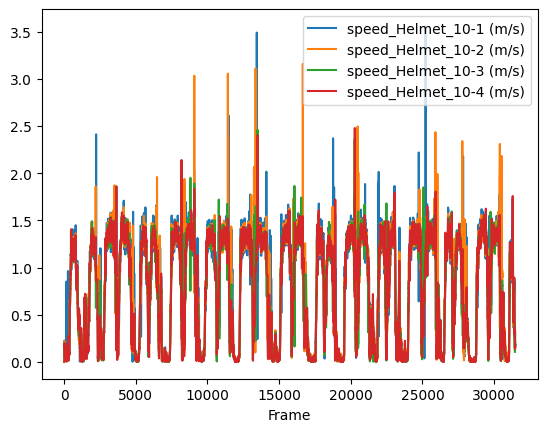

In [14]:
speed_df.reset_index().plot(
    x="Frame",
    y=[
        "speed_Helmet_10-1 (m/s)",
        "speed_Helmet_10-2 (m/s)",
        "speed_Helmet_10-3 (m/s)",
        "speed_Helmet_10-4 (m/s)",
    ],
)

<AxesSubplot: xlabel='Frame'>

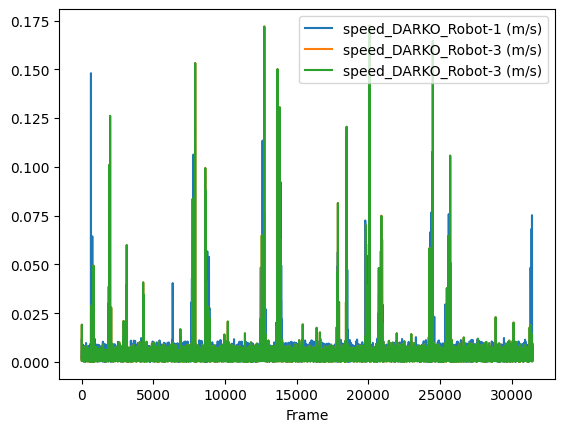

In [24]:
speed_df.reset_index().plot(
    x="Frame",
    y=[
        "speed_DARKO_Robot-1 (m/s)",
        "speed_DARKO_Robot-3 (m/s)",
        "speed_DARKO_Robot-3 (m/s)",
    ],
)